In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import chardet
import codecs
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import RussianStemmer
from functools import reduce
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, Lasso, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from nltk.stem.snowball import SnowballStemmer
import re
import pickle

%matplotlib inline

Возьмем отзывы о мобильных телефонах с http://torg.mail.ru/review/goods/mobilephones/

In [2]:
rating_label = "rating"
text_label = "text"

def getReviewsFrom(url):
    page = requests.get(url)
    parser = BeautifulSoup(page.text, "lxml") 
    review_bodies = parser.findAll(
        "div",
        class_ = "review-item__body"
    )
    return map(parseReviewData, review_bodies)
    
def parseReviewData(review_body):
    review_rating = float(
        review_body.find(
            "span",
            class_ = "review-item__rating-counter"
        ).text.replace(",", ".")
    )
    review_content = review_body.find(
        "div",
        class_ = "review-item__content"
    )
    review_text = getTextFromContent(review_content)
    return {text_label: review_text, rating_label: review_rating}

def getTextFromContent(review_content):
    return ". ".join(
        map(
            getFullTextFromP,
            review_content.findAll("p", class_ = "review-item__paragraph")
        )
    )
    
def getFullTextFromP(p_tag):
    full_text_tag = p_tag.find(
        "a",
        class_ = "more js-ustat_link js-ustat_link_readMore js-ustat_pseudo_link"
    )
    return (full_text_tag["full-text"] if full_text_tag else p_tag.text).strip()

In [3]:
def appendReviewsFrom(df, url):
    print("parsing: {}".format(url))
    rs = list(getReviewsFrom(url))
    return pd.concat([df, pd.DataFrame(rs)], ignore_index=True)

url_template = "http://torg.mail.ru/review/goods/mobilephones/?page={}"
page_nums = range(1, 100)

urls = [url_template.format(p) for p in page_nums]

train_raw_data = reduce(
    appendReviewsFrom,
    urls,
    pd.DataFrame(columns=[text_label, rating_label])
)

train_raw_data.head()

parsing: http://torg.mail.ru/review/goods/mobilephones/?page=1
parsing: http://torg.mail.ru/review/goods/mobilephones/?page=2
parsing: http://torg.mail.ru/review/goods/mobilephones/?page=3
parsing: http://torg.mail.ru/review/goods/mobilephones/?page=4
parsing: http://torg.mail.ru/review/goods/mobilephones/?page=5
parsing: http://torg.mail.ru/review/goods/mobilephones/?page=6
parsing: http://torg.mail.ru/review/goods/mobilephones/?page=7
parsing: http://torg.mail.ru/review/goods/mobilephones/?page=8
parsing: http://torg.mail.ru/review/goods/mobilephones/?page=9
parsing: http://torg.mail.ru/review/goods/mobilephones/?page=10
parsing: http://torg.mail.ru/review/goods/mobilephones/?page=11
parsing: http://torg.mail.ru/review/goods/mobilephones/?page=12
parsing: http://torg.mail.ru/review/goods/mobilephones/?page=13
parsing: http://torg.mail.ru/review/goods/mobilephones/?page=14
parsing: http://torg.mail.ru/review/goods/mobilephones/?page=15
parsing: http://torg.mail.ru/review/goods/mobilep

,rating,text
0,4.0,Пользуюсь телефоном довольно долго.Нареканий н...
1,5.0,"Я раньше ему ставил 4,а сейчас после того как ..."
2,3.0,Не долгожитель!!!!! умер через 1 год использов...
3,5.0,Пользуюсь 2 дня. Эйфория прошла на 12 минуте. ...
4,5.0,"Все радует, особенно батарея, которая при свое..."


In [4]:
train_raw_data.to_csv("train.csv", sep=",")

In [3]:
train_raw_data = pd.read_csv("train.csv", index_col=0)

,rating,text,label
0,4.0,Пользуюсь телефоном довольно долго.Нареканий н...,1
1,5.0,"Я раньше ему ставил 4,а сейчас после того как ...",1
2,3.0,Не долгожитель!!!!! умер через 1 год использов...,0
3,5.0,Пользуюсь 2 дня. Эйфория прошла на 12 минуте. ...,1
4,5.0,"Все радует, особенно батарея, которая при свое...",1


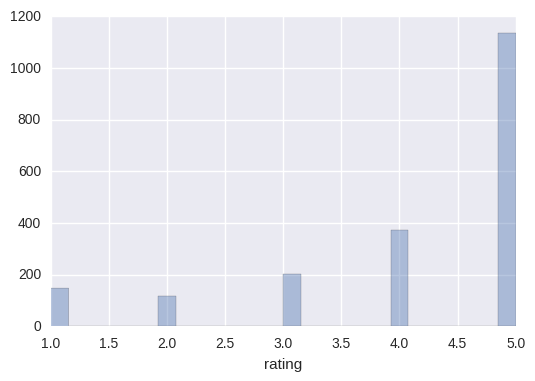

In [4]:
sns.distplot(train_raw_data.rating, norm_hist=False, kde=False)
train_raw_data["label"] = train_raw_data.rating.apply(lambda r: 1 if r >= 4 else 0)
train_raw_data.head()

In [5]:
stemmer = SnowballStemmer("russian")
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

In [6]:
# vectorizers
vects = {
    "cnt": CountVectorizer(),
    "tfidf": TfidfVectorizer() 
}

# classifiers
clfs = {
    "log": LogisticRegression(),
#    "sgd": SGDClassifier(),
#    "svc": LinearSVC(),
#    "mlt": MultinomialNB()
}

# all (vectorizer, classifier) combinations
pipes = {}
for (v_name, vect) in vects.items():
    for (c_name, clf) in clfs.items():
        pipes["{}|{}".format(v_name, c_name)] = Pipeline([
            ('vect', vect),
            ('clf', clf),
        ])

In [7]:
# vectorizer and classifier parameters for gird serach
parameters_sgd = {
    'vect__max_df': list(1-0.05*i for i in range(0, 3)),
    'vect__min_df': list(0.02*i for i in range(0, 3)),
    'vect__ngram_range': ((1, 1), (1, 2), (2, 2)), 
    'vect__analyzer': [stemmed_words],
    'clf__alpha': list(10**i for i in range(-4, -1)),
    'clf__loss': ('hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'),
    'clf__penalty': ("l1", "l2", "elasticnet")
}

parameters_log = {
    'vect__max_df': list(1-0.05*i for i in range(0, 2)),
    'vect__min_df': list(0.02*i for i in range(0, 2)),
    'vect__ngram_range': ((1, 1), (1, 2), (2, 2)),
    'vect__analyzer': [stemmed_words],
    'clf__C': list(10**i for i in range(-3, 3)),
    'clf__penalty': ("l1", "l2")
}

parameters_svc = {
    'vect__max_df': list(1-0.05*i for i in range(0, 2)),
    'vect__min_df': list(0.02*i for i in range(0, 2)),
    'vect__ngram_range': ((1, 1), (1, 2)),
    'vect__analyzer': [stemmed_words],
    'clf__C': list(10**i for i in range(-3, 2)),
}

parameters_mlt = {
    'vect__max_df': list(1-0.05*i for i in range(0, 3)),
    'vect__min_df': list(0.02*i for i in range(0, 3)),
    'vect__ngram_range': ((1, 1), (1, 2), (2, 2)),
    'vect__analyzer': [stemmed_words],
    'clf__alpha': list(10**i for i in range(-3, 3)),
}

params = {
    "log": parameters_log,
    "sgd": parameters_sgd,
    "svc": parameters_svc,
    "mlt": parameters_mlt,
}

In [ ]:
def print_result(gs_cv):
    print("{}:".format(p_name))
    print("Best score: {}".format(gs_cv.best_score_))
    print("Best params: ")
    print(gs_cv.best_params_)
    print("========================================")


best_clfs = {} # map to store pipes with best params

# run grid search for all pipes
for (p_name, pipe) in pipes.items():
    gs_cv = GridSearchCV(pipe, params[p_name.split("|")[1]], cv=3)
    gs_cv.fit(train_raw_data.text, train_raw_data.label)
    print_result(gs_cv)
    best_clfs[p_name] = gs_cv.best_estimator_

In [38]:
def save_clf(clf_name):
    with open("{}.pkl".format(clf_name.replace("|","_")), "wb") as f:
        pickle.dump(best_clfs[clf_name], f)

save_clf("cnt|log") # ждать опитимизации других не хватило времени